In [1]:

import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/kaggle/input/qwen2.5-math/transformers/1.5b/1/config.json
/kaggle/input/qwen2.5-math/transformers/1.5b-instruct/1/config.json
/kaggle/input/qwen2.5/transformers/0.5b-instruct/1/config.json
/kaggle/input/qwen2.5/transformers/0.5b/1/config.json
/kaggle/input/math-dataset/MATH/README.txt
/kaggle/input/math-dataset/MATH/test/prealgebra/1566.json
/kaggle/input/math-dataset/MATH/test/number_theory/1125.json
/kaggle/input/math-dataset/MATH/test/counting_and_probability/212.json
/kaggle/input/math-dataset/MATH/test/precalculus/1125.json
/kaggle/input/math-dataset/MATH/test/geometry/1125.json
/kaggle/input/math-dataset/MATH/test/algebra/1125.json
/kaggle/input/math-dataset/MATH/test/intermediate_algebra/1566.json
/kaggle/input/math-dataset/MATH/train/prealgebra/212.json
/kaggle/input/math-dataset/MATH/train/number_theory/546.json
/kaggle/input/math-dataset/MATH/train/counting_and_probability/5089.json
/kaggle/input/math-dataset/MATH/train/precalculus/546.json
/kaggle/input/math-dataset/MATH/tr

In [2]:
import numpy as np 
import pandas as pd
import os
import re
from torch.utils.data import Dataset
import json
import torch
from transformers import AutoModelForCausalLM,AutoTokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import AdamW
from nltk.translate.bleu_score import sentence_bleu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
!pip install peft
!pip install wandb
#!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
#!pip install vllm
import wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 8.5 MB/s eta 0:00:00:00:01


In [21]:
def extract_answer(solution):
    pattern = r'\\boxed{([^}]*)}'
    match = re.search(pattern, solution)
    if match:
        return match.group(1)
    else:
        return 0



class MathDataset(Dataset):
    
    def __init__(self, base_path, tokenizer=None, subset='train', max_length=512):
        self.base_path = base_path
        self.subset = subset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.problems, self.solutions = self.load_data()

    def load_data(self):
        types_dir = os.listdir(os.path.join(self.base_path, self.subset))
        problems = []
        solutions = []

        for type_dir in types_dir:
            type_path = os.path.join(self.base_path, self.subset, type_dir)
            math_files = os.listdir(type_path)[:300]

            for math_file in math_files:
                math_path = os.path.join(type_path, math_file)
                with open(math_path, 'r') as f:
                    sample = json.load(f)
                    problems.append(sample['problem'])
                    solutions.append(sample['solution'])

        return problems, solutions
        
    def __len__(self):
        return len(self.problems)
    
    def __getitem__(self, idx):
        problem = self.problems[idx]
        solution = self.solutions[idx]
        #ans=extract_answer(self.solutions[idx])

        if self.tokenizer:
            problem_encodings = self.tokenizer(problem, truncation=True, padding='max_length', max_length=self.max_length)
            solution_encodings = self.tokenizer(solution, truncation=True, padding='max_length', max_length=self.max_length)
            #ans_encoding=self.tokenizer(ans, truncation=True, padding='max_length', max_length=self.max_length)
            
            labels = solution_encodings['input_ids']
            labels = [-100 if token == self.tokenizer.pad_token_id else token for token in labels]

            return {
                'input_ids': torch.tensor(problem_encodings['input_ids']),
                'attention_mask': torch.tensor(problem_encodings['attention_mask']),
                'labels': torch.tensor(labels),
                #'answer': torch.tensor(ans_encoding['input_ids'])
            }
        else:
            return problem, solution





def evaluate(dataloader, model):
    
    all_loss = 0
    all_bleu=0
    all_acc=0
    total_correct = 0
    total_tokens = 0
    example=1
    correct_answer=0
    n=2100
    
    with torch.no_grad():
        
        
        for batch in dataloader:
            #print(device)
            batch = {k: v.to(device) for k, v in batch.items()}
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            #ans=batch['answer'].to(device)
            
            outputs = model(**batch)
            loss = outputs.loss
            #print("loss: ",loss.item())
            
            logits = outputs.logits
            all_loss += loss.item()
            #pbar.set_postfix({"loss": f"{loss.item():.4f}"})
            
            _, predicted = torch.max(logits, dim=-1)
            predicted = predicted.view(-1)
            labels = labels.view(-1)
            mask = labels != -100
            predicted = predicted[mask]
            labels = labels[mask]
            predicted = predicted.tolist()
            labels = labels.tolist()

            correct = sum(1 for pred, label in zip(predicted, labels) if pred == label)
            total_correct += correct
            total_tokens += len(labels)
            
            accuracy = total_correct / total_tokens
            #print("accuracy: ", accuracy)
            all_acc+=accuracy

            decod_label=tokenizer.decode(labels,skip_special_tokens=True)
            decod_pred=tokenizer.decode(predicted,skip_special_tokens=True)
            
            bleu_score = sentence_bleu([decod_label], decod_pred)
            #print("bleu_score: ", bleu_score)
            all_bleu+=bleu_score


            predicted_answer=extract_answer(decod_pred)
            if predicted_answer== extract_answer(decod_label):
                correct_answer+=1

            
            if(example):
                example=0
                decod_labels=tokenizer.decode(labels)
                decod_pred=tokenizer.decode(predicted)
                print("Example:")
                print("Label:",decod_labels)
                print("Predicted",decod_pred)
                
            
        
    #pbar.close()
    avg_loss = all_loss / n
    avg_bleu=all_bleu / n
    avg_acc=all_acc / n
    part_correct=correct_answer/n
    print(f"average loss: {avg_loss:.4f}")
    print(f"average bleu: {avg_bleu:.4f}")
    print(f"average accuracy: {avg_acc:.4f}")
    print(f"part of correct answers: {part_correct:.4f}")
    
    return avg_loss,avg_bleu,avg_acc,part_correct



# 

def train(model, train_dataloader,test_dataloader,optimizer, epochs=3, use_peft=False):
    
    wandb.init(project="Мой проект", entity="izutkinaalexandra-bmstu")
    n=2100
    i=0
    for epoch in range(epochs):
        #progress_bar = tqdm(range(len(train_dataloader)), desc=f"Epoch {epoch + 1}/{epochs}")
        epoch_loss = 0
        for batch in train_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                loss.backward()
        
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
                if(use_peft):
                    # Замораживаем веса основной модели
                    for param in model.base_model.parameters():
                        param.grad = None

                #print("loss",loss.item())
                i+=1
                if(i==20):
                    i=0
                    wandb.log({"loss": loss.item()})  # Логгируем loss
                #progress_bar.update(1)
                #progress_bar.set_postfix({"loss": loss.item()})
        
                epoch_loss += loss.item()
        
        #progress_bar.close()
        avg_loss = epoch_loss / n
        print(f"Epoch {epoch + 1} average loss: {avg_loss:.4f}")
        avg_loss, bleu,acc, corr=evaluate(test_dataloader, model)
        loss_values.append(avg_loss)
        wandb.log({"val_loss": avg_loss})  
        
    wandb.finish()

In [ ]:
#GPT2

BASE_PATH='/kaggle/input/math-dataset/MATH'
model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

train_dataset = MathDataset(base_path=BASE_PATH, subset='train', tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = MathDataset(base_path=BASE_PATH, subset='test', tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

#используется функция потерь CrossEntropyLoss с логарифмическим softmax-вычислением.

evaluate(train_dataloader,model)

#В модели GPT-2 eos_token равен </s>.
#truncation=True - токенизатор будет обрезать входной текст до максимальной длины,
#если он превышает ее.
#GPT2 принимает на вход только последовательности токенов фиксированной длины(max_length)



In [5]:
# launch train


from transformers import AdamW, get_scheduler


wandb.init(project="GPT2", name="all")
epochs=2
learning_rate = 1e-4
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
loss_values = []
model.train()
train(model, train_dataloader,test_dataloader,optimizer, epochs=4)

# 

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 average loss: 1.3956
average loss: 1.3598
average bleu: 0.0199
average accuracy: 0.0109
part of correct answers: 0.0005
Epoch 2 average loss: 1.3308
average loss: 1.3471
average bleu: 0.0255
average accuracy: 0.0113
part of correct answers: 0.0005
Epoch 3 average loss: 1.3123
average loss: 1.3471
average bleu: 0.0261
average accuracy: 0.0114
part of correct answers: 0.0005
Epoch 4 average loss: 1.3127
average loss: 1.3473
average bleu: 0.0259
average accuracy: 0.0113
part of correct answers: 0.0005


loss,▆▆▅▃▄▅▅▄█▅▃▂▂▃▄▁▄▃▅▃▄▅▄▆▃▅▅▅▄▂▃▄▂▃▂▄▄▂▃▄
val_loss,█▁▁▁
loss,5.40779
val_loss,1.34733


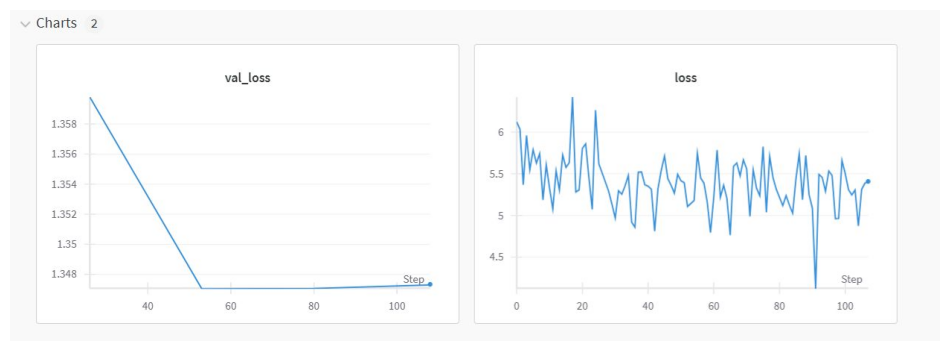

In [20]:
# Импортируем необходимые библиотеки
from PIL import Image
import matplotlib.pyplot as plt

# Указываем путь к изображению
image_path = '/kaggle/input/gpt-loss/gpt_loss.jpg'  # Замените your_image_file.jpg на имя вашего файла

# Загружаем изображение
img = Image.open(image_path)
plt.figure(figsize=(12, 8)) 
# Отображаем изображение
plt.imshow(img)
plt.axis('off')  # Отключаем оси
plt.show()


In [ ]:
# неудовлетворительные результаты

In [22]:
evaluate(train_dataloader,model)

Example:
Label: We see that the expression is equal to $3^3 + 3^2 + 3 + 1 = 27 + 9 + 3 + 1 = \boxed{40}$.If $d \neq 0$, the value of the expression can be increased by interchanging 0 with the value of $d$.  Therefore the maximum value must occur when $d=0$.  If $a = 1$, the value is $c$, which is 2 or 3.  If $b=1$, the value is $c \cdot a = 6$.  If $c=1$, the value is $a^b$, which is $2^3 = 8$ or $3^2 = 9$.  Thus the maximum value is $\boxed{9}$.Since each coin has 2 possible outcomes, there are $2^n$ possible outcomes for the $n$ coins.  The number of outcomes in which the number of tails is 0 or 1 is $\binom{n}{0}+\binom{n}{1}=1+n$.  So the probability of having at most one tail is $\dfrac{1+n}{2^n}$.  Therefore, we must solve the equation $$ \frac{1+n}{2^n} =\frac{3}{16}. $$ We can check (simply by plugging in values of $n$) that if $1 \leq n \leq 5$, then $n=5$ is the only solution.  Now we show that $n\geq 6$ cannot be a solution to the equation.  Observe that $n\geq 6$ implies $

(1.3122212017150152, 0.026909324084724292, 0.012809871540961361, 0.0)

In [13]:
# Посчитаем метрики у модели обученной на математических датасетах - qwen2.5-math/transformers/1.5b-instruct

from nltk.translate.bleu_score import sentence_bleu
import re
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import gc
import os
import json

BASE_PATH='/kaggle/input/math-dataset/MATH'

from transformers import AutoTokenizer, AutoModelForCausalLM


tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/qwen2.5-math/transformers/1.5b-instruct/1")

model = AutoModelForCausalLM.from_pretrained(
    "/kaggle/input/qwen2.5-math/transformers/1.5b-instruct/1",
    device_map="auto",
    torch_dtype=torch.bfloat16
)
model.to(device)
EOS_TOKEN = tokenizer.eos_token

def load_data(base_path=BASE_PATH, subset='train'):
        types_dir = os.listdir(os.path.join(base_path, subset))
        problems = []
        solutions = []

        for type_dir in types_dir:
            type_path = os.path.join(base_path, subset, type_dir)
            math_files = os.listdir(type_path)

            for math_file in math_files:
                math_path = os.path.join(type_path, math_file)
                with open(math_path, 'r') as f:
                    sample = json.load(f)
                    problems.append(sample['problem'])
                    solutions.append(sample['solution'])

        return {"input": problems, "output": solutions}


dataset=load_data()

def extract_answer(solution):
    pattern = r'\\boxed{([^}]*)}'
    match = re.search(pattern, solution)
    if match:
        return match.group(1)
    else:
        pattern = r'\boxed{([^}]*)}'
        match = re.search(pattern, solution)
        if match:
            return match.group(1)
        else:
            return 0



def calculate_metrics(model,dataset):
    torch.cuda.empty_cache()
    gc.collect()
    model.eval()
    all_loss = 0
    all_bleu=0
    losses=0
    all_acc=0
    total_correct = 0
    total_tokens = 0
    example=1
    correct_answer=0
    alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

        ### Instruction:
        {}

        ### Input:
        {}
        ### Response:
        {} """

    inputs = dataset["input"][:4]
    outputs = dataset["output"][:4]
    instruction="Please reason step by step, and put your final answer within \\boxed{}"
    texts = []

    for input0, output0 in zip(inputs, outputs):
        text = alpaca_prompt.format(instruction,input0, output0) + EOS_TOKEN
        texts.append(text)
        
    #labels = tokenizer(outputs, return_tensors='pt', padding=True, truncation=True)['input_ids'].to(device)
    encoding=tokenizer(texts,return_tensors='pt', padding=True, truncation=True).to(device)
    out=model(**encoding )
    
    
    predicted_ids = out.logits.argmax(dim=-1)
    decoded_outputs = [tokenizer.decode(ids, skip_special_tokens=True) for ids in predicted_ids]

    n=len(decoded_outputs)

    for i in range(len(decoded_outputs)):

        bleu_score = sentence_bleu([outputs[i]], decoded_outputs[i])
        all_bleu+=bleu_score

        correct = sum(1 for pred, label in zip(decoded_outputs[i], outputs[i]) if pred == label)
        total_correct += correct
        total_tokens += len(outputs[i])
        accuracy = total_correct / total_tokens
        all_acc+=accuracy

        if extract_answer(decoded_outputs[i])== extract_answer(outputs[i]):
                correct_answer+=1

    
    avg_bleu=all_bleu / n
    avg_acc=all_acc / n
    part_correct=correct_answer/n

    
    print(f"average bleu: {avg_bleu:.4f}")
    print(f"average accuracy: {avg_acc:.4f}")
    print(f"part of correct answers: {part_correct:.4f}")

calculate_metrics(model, dataset)

average bleu: 0.2873
average accuracy: 0.0739
part of correct answers: 0.2500


## Черновики

In [47]:
# initilizing dataset and model

from transformers import AutoTokenizer, AutoModelForCausalLM


tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/qwen2.5-math/transformers/1.5b-instruct/1")

model = AutoModelForCausalLM.from_pretrained(
    "/kaggle/input/qwen2.5-math/transformers/1.5b-instruct/1",
    device_map="auto",
    torch_dtype=torch.bfloat16
)

BASE_PATH='/kaggle/input/math-dataset/MATH'

train_dataset = MathDataset(base_path=BASE_PATH, subset='train', tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = MathDataset(base_path=BASE_PATH, subset='test', tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)


from transformers import AdamW, get_scheduler
evaluate(train_dataloader, model)

epochs = 2
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)


average loss: 7.6011
average bleu: 0.0467
average accuracy: 0.0037
part of correct answers: 0.0048


In [ ]:
train(model,train_dataloader)

In [48]:


# Qwen2.5-math



tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/qwen2.5/transformers/0.5b-instruct-awq/1")
model = AutoModelForCausalLM.from_pretrained(
    "/kaggle/input/qwen2.5/transformers/0.5b-instruct-awq/1",
    device_map="auto",
    torch_dtype=torch.bfloat16
)

BASE_PATH='/kaggle/input/math-dataset/MATH'

train_dataset = MathDataset(base_path=BASE_PATH, subset='train', tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = MathDataset(base_path=BASE_PATH, subset='test', tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

evaluate(train_dataloader, model)

average loss: 6.3628
average bleu: 0.0466
average accuracy: 0.0091
part of correct answers: 0.0033


(6.362764618737357,
 0.04662015916645866,
 0.009074703775559587,
 0.0033333333333333335)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType


model = AutoModelForCausalLM.from_pretrained(
    "/kaggle/input/qwen2.5-math/transformers/1.5b/1", 
    device_map="auto", 
    torch_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/qwen2.5-math/transformers/1.5b/1")

lora_config = LoraConfig(
    r=8,  # Ранг для LoRA
    lora_alpha=64,  # Альфа для LoRA
    lora_dropout=0.1,  # Дропаут для LoRA
    task_type=TaskType.SEQ_2_SEQ_LM  #QUESTION_ANS #SEQ_2_SEQ_LM   # Тип задачи
)

lora_model = get_peft_model(model, lora_config)

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="kaggle/working/",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=1,
    save_steps=500,
)

# Создание тренера
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
)

# Обучение модели
trainer.train()




In [ ]:
# model_name = "deepseek-ai/deepseek-math-7b-instruct"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto")
# model.generation_config = GenerationConfig.from_pretrained(model_name)
# model.generation_config.pad_token_id = model.generation_config.eos_token_id

# messages = [
#     {"role": "user", "content": "what is the integral of x^2 from 0 to 2?\nPlease reason step by step, and put your final answer within \\boxed{}."}
# ]
# input_tensor = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")
# outputs = model.generate(input_tensor.to(model.device), max_new_tokens=100)

# result = tokenizer.decode(outputs[0][input_tensor.shape[1]:], skip_special_tokens=True)
# print(result)